# Step 2

### Target
- Make the model lighter (< 8K parameters)
- Dropouts and GAP implemented

### Result
- Parameters: 7002 
- Best Training Accuracy: 99.50% (15th Epoch)
- Best Test Accuracy: 99.25% (10th Epoch)

### Analysis
- Good model, The gap between training and test accuracy is less
- Training accuracy is 99.50% in the last epoch, model is slow in learning ?


### Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### Perform Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                   # transforms.Resize((28, 28)),
                   # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                   # Note the difference between (0.1307) and (0.1307,)
                   ])

# Test Phase transformations
test_transforms = transforms.Compose([
                   # transforms.Resize((28, 28)),
                   # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                   ])


### Download Dataset and Create Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

### Initialize Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 5
BATCH_SIZE = 128
CUDA_BATCH_SIZE = 64

# Use CUDA if available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# Dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=CUDA_BATCH_SIZE)

# Train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# Test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


### Data Statistics

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


D:\Software\Anaconda3\envs\pytorch25\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([128, 1, 28, 28])
torch.Size([128])


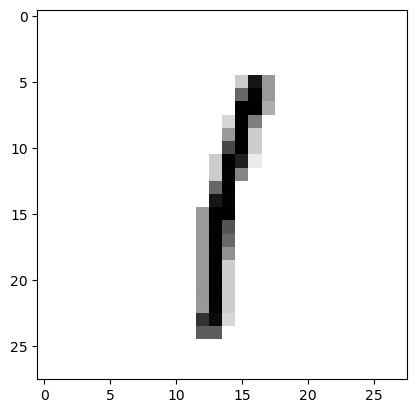

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

### Some data visualization

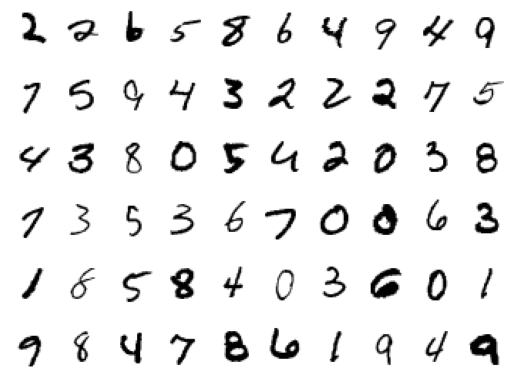

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### How did we get those mean and std values which we used above?

In [7]:
# simple transform
simple_transforms = transforms.Compose([
                    # transforms.Resize((28, 28)),
                    # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                    transforms.ToTensor(),
                    # transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                    # Note the difference between (0.1307) and (0.1307,)
                    ])

exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


D:\Software\Anaconda3\envs\pytorch25\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


### The Model and its parameters

In [8]:
# This notebook experiment uses Net2() model in Models.py
from Models import get_model2, save_model

### Model Summary

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = get_model2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3           [-1, 16, 24, 24]           1,168
       BatchNorm2d-4           [-1, 16, 24, 24]              32
           Dropout-5           [-1, 16, 24, 24]               0
         MaxPool2d-6           [-1, 16, 12, 12]               0
            Conv2d-7            [-1, 8, 12, 12]             136
       BatchNorm2d-8            [-1, 8, 12, 12]              16
            Conv2d-9           [-1, 16, 10, 10]           1,168
      BatchNorm2d-10           [-1, 16, 10, 10]              32
           Conv2d-11             [-1, 16, 8, 8]           2,320
      BatchNorm2d-12             [-1, 16, 8, 8]              32
          Dropout-13             [-1, 16, 8, 8]               0
        MaxPool2d-14             [

### Define the functions for Training and Testing

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # Get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Training: Batch_id={batch_idx} Loss={loss.item()} Accuracy={100 * correct / processed:0.2f}')
    train_acc.append(100 * correct / processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### Let's Train and test our model

In [11]:
model =  get_model2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Training: Batch_id=468 Loss=0.11199477314949036 Accuracy=92.74: 100%|████████████████| 469/469 [00:09<00:00, 48.02it/s]


Test set: Average loss: 0.0717, Accuracy: 9807/10000 (98.07%)

EPOCH: 1


Training: Batch_id=468 Loss=0.031128915026783943 Accuracy=98.13: 100%|███████████████| 469/469 [00:09<00:00, 48.39it/s]


Test set: Average loss: 0.0479, Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Training: Batch_id=468 Loss=0.016535433009266853 Accuracy=98.55: 100%|███████████████| 469/469 [00:09<00:00, 48.32it/s]


Test set: Average loss: 0.0404, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Training: Batch_id=468 Loss=0.0486164391040802 Accuracy=98.86: 100%|█████████████████| 469/469 [00:09<00:00, 47.80it/s]


Test set: Average loss: 0.0339, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Training: Batch_id=468 Loss=0.012790183536708355 Accuracy=99.00: 100%|███████████████| 469/469 [00:09<00:00, 47.43it/s]


Test set: Average loss: 0.0317, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Training: Batch_id=468 Loss=0.036671992391347885 Accuracy=99.08: 100%|███████████████| 469/469 [00:09<00:00, 49.44it/s]


Test set: Average loss: 0.0271, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Training: Batch_id=468 Loss=0.0325327031314373 Accuracy=99.17: 100%|█████████████████| 469/469 [00:09<00:00, 49.49it/s]


Test set: Average loss: 0.0267, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Training: Batch_id=468 Loss=0.01603865437209606 Accuracy=99.15: 100%|████████████████| 469/469 [00:09<00:00, 48.03it/s]


Test set: Average loss: 0.0295, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Training: Batch_id=468 Loss=0.04159591719508171 Accuracy=99.27: 100%|████████████████| 469/469 [00:09<00:00, 49.05it/s]


Test set: Average loss: 0.0254, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Training: Batch_id=468 Loss=0.028305605053901672 Accuracy=99.29: 100%|███████████████| 469/469 [00:09<00:00, 48.38it/s]


Test set: Average loss: 0.0292, Accuracy: 9900/10000 (99.00%)

EPOCH: 10


Training: Batch_id=468 Loss=0.004234873689711094 Accuracy=99.34: 100%|███████████████| 469/469 [00:09<00:00, 48.95it/s]


Test set: Average loss: 0.0257, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Training: Batch_id=468 Loss=0.001978579442948103 Accuracy=99.36: 100%|███████████████| 469/469 [00:09<00:00, 47.72it/s]


Test set: Average loss: 0.0262, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Training: Batch_id=468 Loss=0.012127597816288471 Accuracy=99.40: 100%|███████████████| 469/469 [00:09<00:00, 48.24it/s]


Test set: Average loss: 0.0228, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Training: Batch_id=468 Loss=0.02754250355064869 Accuracy=99.45: 100%|████████████████| 469/469 [00:09<00:00, 47.66it/s]


Test set: Average loss: 0.0235, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Training: Batch_id=468 Loss=0.0006776804220862687 Accuracy=99.50: 100%|██████████████| 469/469 [00:09<00:00, 48.36it/s]


Test set: Average loss: 0.0259, Accuracy: 9918/10000 (99.18%)



### Plot the Training and Tests - Accuracy and losses

In [12]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

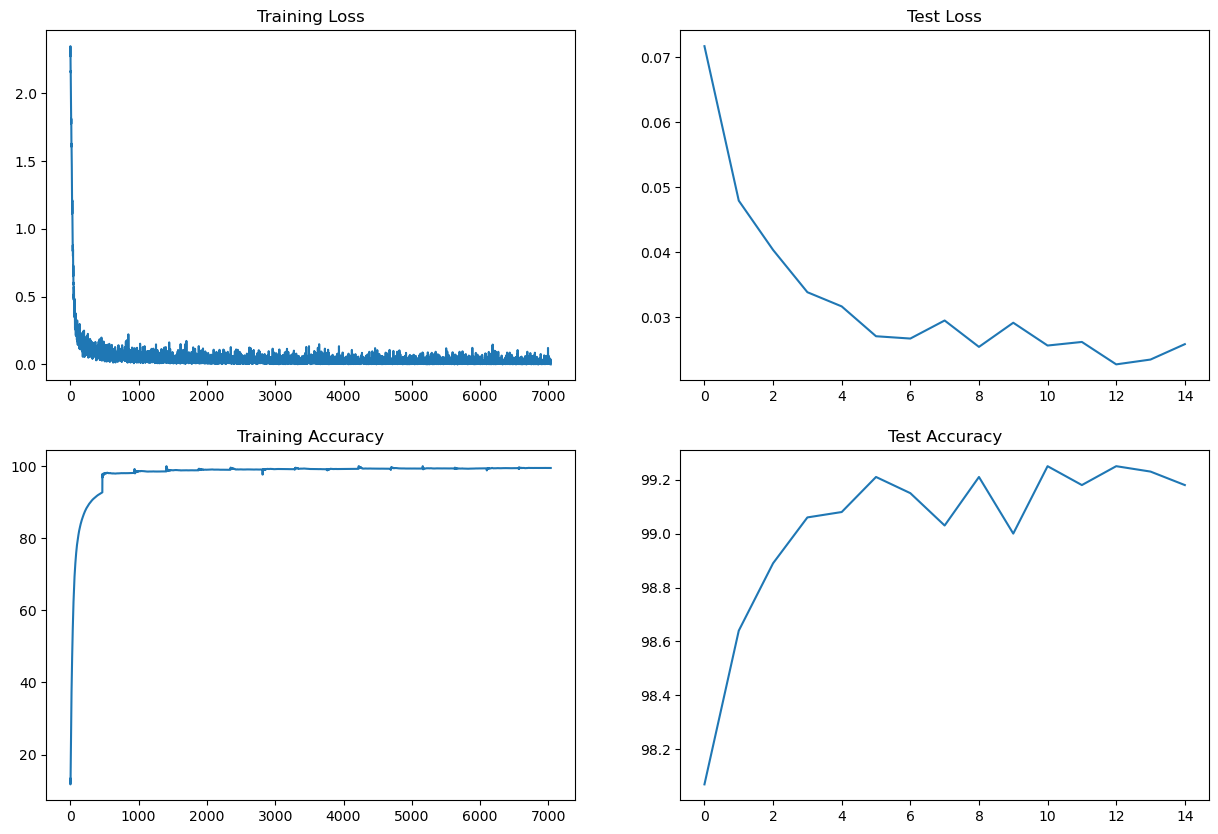

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15, 10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")